# Cross-validation and Metrics in Time Series Forecasting

This tutorial demonstrates proper cross-validation techniques and evaluation metrics for time series forecasting.

**Duration:** ~10 minutes

## Learning objectives

By the end of this tutorial, you will be able to:
- Use time series splitters for proper cross-validation
- Visualize cross-validation windows with `plot_windows`
- Apply various forecasting metrics
- Use the `evaluate` function for comprehensive model assessment

### Context & recap

In earlier tutorials you:
- Fit a first univariate forecaster (baseline mindset)
- Applied transformations to `y` safely
- Introduced exogenous variables (`X`) and how/when they help
- Wrapped steps in pipelines to avoid leakage and keep workflows reproducible

Cross-validation (CV) is the glue that now lets you *trust* performance numbers and compare alternatives fairly. In time series, "just use random k-fold" is wrong because it breaks temporal order. Here we focus on **rolling/blocked CV strategies** that respect time, produce realistic error estimates, and let you inspect how accuracy changes with the forecast horizon.

Two recurring design choices:
1. How to grow or move the training window (expanding vs sliding)
2. Which future points you evaluate at each fold (the forecast horizon `fh`)

The choice should mirror your real forecasting scenario, and what your model will face in production.

## 1. Time Series Cross-validation Splitters

Time series data requires special consideration for cross-validation due to temporal dependencies.

### Mimic your production update cycle

Instead of asking “expanding vs sliding – which is better?”, start with a simpler question:
**How will my model be updated in real life?**

Match the CV splitter to that process:
- If in production you keep *all* past data and refit (batch retrain), use an **expanding window** – each fold simulates a future retrain moment.
- If you retrain on only the most recent chunk (because of drift / storage / latency), use a **sliding window** with that window length.

`fh` (forecast horizon) should also mirror usage: if stakeholders consume a 1–12 month forecast each month, evaluate those 12 relative steps: `[1,2,...,12]`. If you only ever consume a 1-step-ahead rolling forecast, keep `fh=[1]` – broader horizons just add noise.

So: design CV to *replay your deployment timeline*. That gives performance numbers you can trust operationally.

Below we instantiate two common update patterns so you can compare their *shape*.


## 1.1 Load data

<Axes: xlabel='Period'>

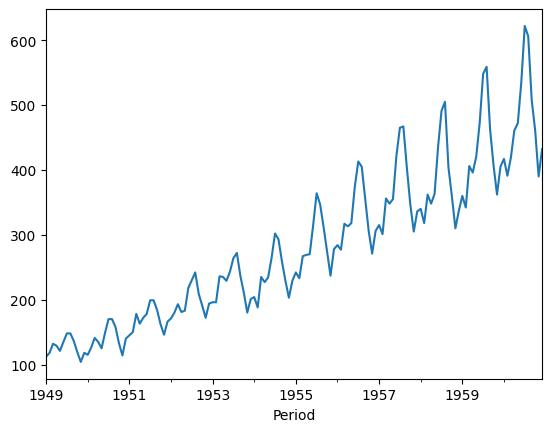

In [16]:
import matplotlib.pyplot as plt

from sktime.datasets.forecasting import Airline

y = Airline().load("y")
y.plot.line()

## 1.2 Visualize CV splitters


Reading the diagram:
- Each row = one CV fold
- Blue block = history used to fit the model for that fold
- Orange block = points predicted & scored (`fh` offsets)


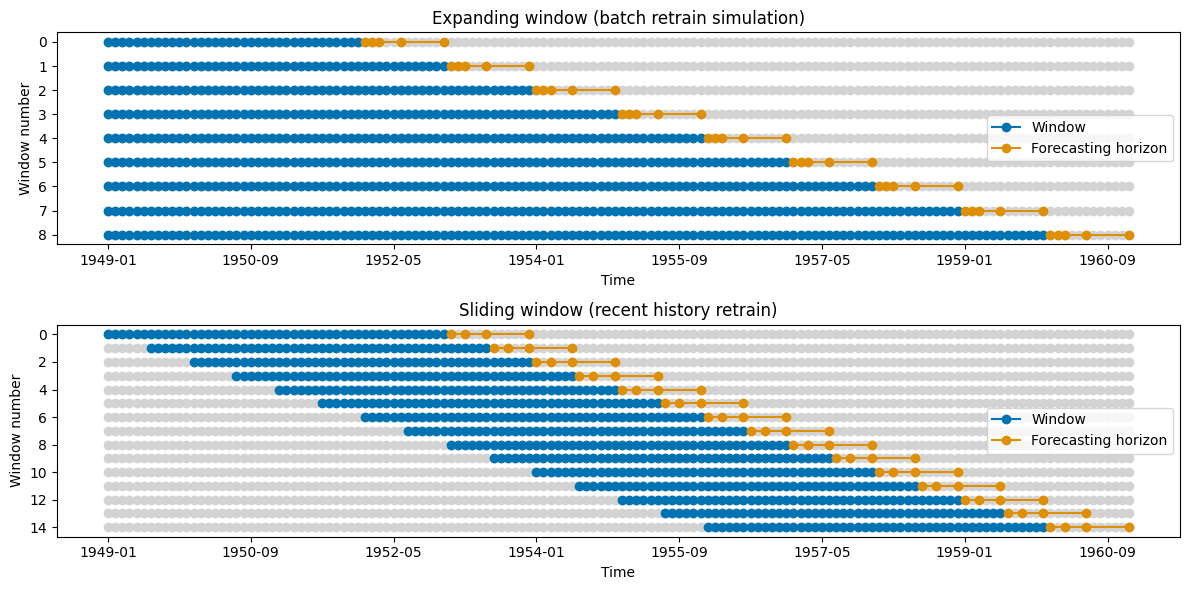

In [17]:
from sktime.split import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
)
from sktime.utils.plotting import plot_windows

# Load data
# Two deployment patterns
expanding = ExpandingWindowSplitter(
    initial_window=36,
    step_length=12,
    fh=[1, 2, 3, 6, 12],
)
sliding = SlidingWindowSplitter(
    window_length=48,
    step_length=6,
    fh=[1, 3, 6, 12],
)

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
plot_windows(
    expanding, y, ax=axes[0], title="Expanding window (batch retrain simulation)"
)
plot_windows(sliding, y, ax=axes[1], title="Sliding window (recent history retrain)")
plt.tight_layout()

The splitters have a `.split` method that generates the train/test indices for each fold. 
You can of course customize and create your own cross-validation strategies by extending the `BaseSplitter` class. 

In [20]:
idx_list = list(sliding.split(y))
idx_list[0]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 array([48, 50, 53, 59]))

## 1.3 Evaluate CV splits

Sktime has a shortcut for running cross-validation experiments: the `evaluate` function. It takes care of fitting, predicting, and scoring for each fold, and returns a summary of results

In [26]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_squared_error

results = evaluate(
    forecaster=NaiveForecaster(strategy="drift"),
    y=y,
    X=None,  # Pass your X here if using a regression model
    cv=sliding,
    scoring=mean_squared_error,  # We will see more metrics later
)

results

,test__DynamicForecastingErrorMetric,fit_time,pred_time,len_train_window,cutoff
0,757.681530,0.002387,0.002082,48,1952-12
1,861.532141,0.002533,0.002114,48,1953-06
2,889.237890,0.002325,0.002032,48,1953-12
3,1088.750000,0.002222,0.001895,48,1954-06
4,1904.182209,0.002193,0.002295,48,1954-12
5,1455.237211,0.002350,0.001863,48,1955-06
6,1957.298891,0.002326,0.001899,48,1955-12
7,2418.597782,0.002146,0.002863,48,1956-06
8,3072.627094,0.002917,0.002296,48,1956-12
9,3594.895201,0.002269,0.002452,48,1957-06


It returns the metric for every fold, as well and fit and predict times. The model can also be pipelines with transformations, feature selection, and you can pass exogenous variables `X` if needed.

If you want to see the train/test results for each fold, you can use the `return_data=True` argument.

In [27]:
results = evaluate(
    forecaster=NaiveForecaster(strategy="drift"),
    y=y,
    X=None,  # Pass your X here if using a regression model
    cv=sliding,
    scoring=mean_squared_error,  # We will see more metrics later
    return_data=True,
)

results.head(2)

,test__DynamicForecastingErrorMetric,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,757.681530,0.002461,0.002556,48,1952-12,Period 1949-01 112.0 1949-02 118.0 1949-...,Period 1953-01 196.0 1953-03 236.0 1953-...,1953-01 195.744681 1953-03 199.234043 19...
1,861.532141,0.003032,0.007394,48,1953-06,Period 1949-07 148.0 1949-08 148.0 1949-...,Period 1953-07 264.0 1953-09 237.0 1953-...,1953-07 245.021277 1953-09 249.063830 19...


You can use to see the train/test/pred results for each fold.

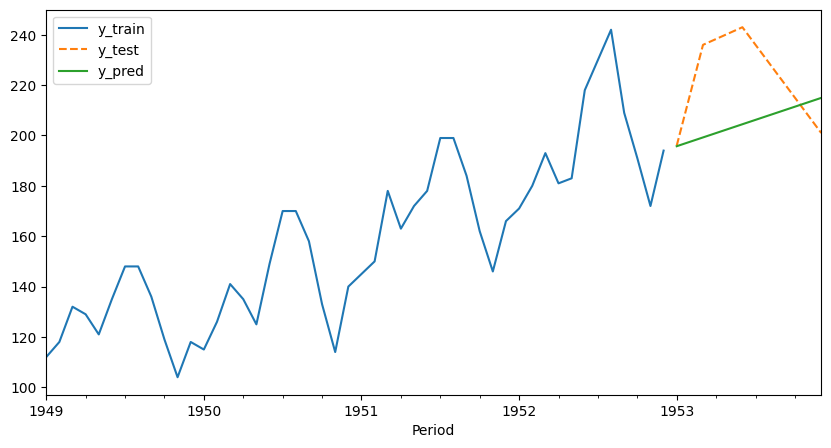

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
results.loc[0, "y_train"].plot.line(ax=ax)
results.loc[0, "y_test"].plot.line(ax=ax, style="--")
results.loc[0, "y_pred"].plot.line(ax=ax)
plt.legend(["y_train", "y_test", "y_pred"])
fig.show()

## 2. Forecasting Metrics

Different metrics capture different aspects of forecast quality. Metrics are first-class citizens in `sktime`, with a variety of options available for different use cases. No single metric dominates; pick the one aligned with decision cost.

The basic signature for metrics is:

```python
metric(y_true, y_pred)
```

But we also have metrics that depend on `y_train` (e.g., MASE). In this case, the signature is:

```python
metric(y_true, y_pred, y_train=y_train)
```

We will see probabilistic metrics in the probabilistic forecasting tutorial.



In [42]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_absolute_scaled_error,
)
from sktime.split import temporal_train_test_split

# Simple hold-out for illustrative metric panel
y_train, y_test = temporal_train_test_split(y, test_size=12)

y_pred = NaiveForecaster(strategy="drift").fit_predict(y=y_train, fh=y_test.index)

In [43]:
mean_absolute_error(y_test, y_pred)

66.30788804071248

In [44]:
mean_absolute_percentage_error(y_test, y_pred)

0.12417957002111175

In [45]:
mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)

2.753195985208664